<h1 align="center">Project : Discerning Bots from Humans in Digital Spaces: An Advanced AI Detection Approach</h1>

<h2 align="center">Leveraging Explainable AI for Enhanced Interpretability</h2>

<h3 align="center"> Led By: Heon Kim, Vincent Caldwell, Mike Meissner</h3>

</div>

## Table of Contents <a class="anchor" id="home"></a>

1. [Importing packages](#imports)
2. [Helper functions](#helper-functions)
3. [Importing data](#import-data)
4. [Feature engineering](#feature-engineering)
5. [Cleaning tweets](#cleaning-tweets)
6. [Sentiment scores using NLTK and VADER lexicon](#nltk-vader)
    - [Clustering](#clustering)
7. [Additional Feature Engineering](#additional-feature-engineering)
    - [Wordcloud of the 50 most common words for bots and nots](#wordcloud)
    - [Indicate if the tweet contains the top 50 words from bot or not](#tweet-contains)
8. [Exploratory Data Analaysis](#eda)
    - [Geographical and Demographical Insights](#geo-and-demo)
    - [Temporal Analysis](#temporal-analysis)
    - [Engagement and Content Analysis](#ec-analysis)
    - [Temporal Dynamics: Activity Trends Over Time](#temporal-dynamics)
    - [Language Complexity and Diversity](#language-complexity)
    - [Topic Modeling](#topic-modeling-eda)
    - [Sentiment Over Time](#sentiment-over-time)
    - [Sentiment and Engagement Correlation](#se-corr)
9. [Machine Learning Models](#machine-learning-models)
    - [Random Forest Classification](#random-forest-classification)
    - [Logistic Regression](#logistic-regression)
    - [Support Vector Machines (SVM)](#support-vector-machines-svm)
    - [K-Nearest Neighbors (KNN)](#k-nearest-neighbors-knn)
    - [Gradient Boosting Machines (GBM), including XGBoost, LightGBM, and CatBoost](#gradient-boosting-machines-gbm-including-xgboost-lightgbm-and-catboost)
    - [Majority Voting: Joined ALL three ensemble methods above](#majority-voting-joined-all-three-ensemble-methods-above)
10. [Neural Networks/Deep Learning](#neural-networksdeep-learning)
    - [Multilayer Perceptrons (MLP)](#multilayer-perceptrons-mlp)
    - [Recurrent Neural Networks (RNN)](#recurrent-neural-networks-rnn)
    - [Long Short-Term Memory (LSTM) Networks](#long-short-term-memory-lstm-networks)
    - [Prediction for RNN and LSTM](#prediction-for-rnn-and-lstm)
11. [Enhancing models with feature selections](#below-are-the-machine-learning-model-that-i-have-used-by-enhancing-feature-selections)
12. [Random Forest Classification Models](#random-forest-classification-models)
    - [Feature Selection 1 using numerical variables only.](#feature-selection-1-using-numerical-variables-only)
    - [Feature Selection 2 using numerical variables only](#feature-selection-2-using-numerical-variables-only)
    - [Feature Selection 3 using categorical variables only.](#feature-selection-3-using-categorical-variables-only)
    - [Feature Selection 4 using categorical variables excluding some features](#feature-selection-4-using-categorical-variables-excluding-some-features)
13. [Using LIME (explainable AI)](#using-lime-explainable-ai)
    - [Lime topic analysis](#lime-topic-analysis)
14. [SHAP (explainable AI)](#using-shap-explainable-ai)

## Importing packages <a class="anchor" id="imports"></a>

In [1]:
# Data Processing and Analysis
import re
import textstat
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from typing import List, Tuple, Any
from collections import Counter

# Feature Engineering and Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, StandardScaler
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Text Processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')

# Machine Learning Model Building
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Neural Network and Deep Learning
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, LSTM, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Model Evaluation and Metrics
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

# Explainability and Interpretation
from lime.lime_text import LimeTextExplainer
import shap


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mike\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mike\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mike\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Mike\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Mike\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[Back to Top](#home)

## Helper functions <a class="anchor" id="helper-functions"></a>

In [2]:
def perform_lda(text_data: List[str]) -> Tuple[LatentDirichletAllocation, CountVectorizer]:
    """
    Performs Latent Dirichlet Allocation (LDA) on the given text data.
    
    Parameters:
        text_data (List[str]): A list of documents in the form of strings.
    
    Returns:
        Tuple[LatentDirichletAllocation, CountVectorizer]: A tuple containing the trained LDA model
        and the CountVectorizer instance used to transform the text data.
    """
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    dtm = vectorizer.fit_transform(text_data)
    
    lda = LatentDirichletAllocation(n_components=5, random_state=0)
    lda.fit(dtm)
    
    return lda, vectorizer


def display_topics(model: LatentDirichletAllocation, feature_names: List[str], no_top_words: int) -> None:
    """
    Displays the top words for each topic from the LDA model.
    
    Parameters:
        model (LatentDirichletAllocation): The LDA model.
        feature_names (List[str]): List of feature names, can be obtained from the vectorizer.
        no_top_words (int): Number of top words to display for each topic.
    """
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))


def create_model(input_dim: int) -> Sequential:
    """
    Creates and compiles a Sequential model for binary classification.
    
    Parameters:
        input_dim (int): The size of the input layer (number of features).
    
    Returns:
        Sequential: A compiled TensorFlow Sequential model.
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, input_dim=input_dim, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


def predict_for_lime(texts: List[str], tokenizer: Tokenizer, model_rnn: Sequential, max_sequence_length: int) -> np.ndarray:
    """
    Generates predictions for a list of texts using an RNN model, formatted for LIME explanation.
    
    Parameters:
        texts (List[str]): A list of texts to predict on.
        tokenizer (Tokenizer): The Keras Tokenizer instance used to tokenize texts.
        model_rnn (Sequential): The trained RNN model.
        max_sequence_length (int): The maximum sequence length for padding.
    
    Returns:
        np.ndarray: An array of predictions, formatted for LIME (two columns: [1-prediction, prediction]).
    """
    sequences = tokenizer.texts_to_sequences(texts)
    data = pad_sequences(sequences, maxlen=max_sequence_length)
    preds = model_rnn.predict(data)
    return np.hstack((1-preds, preds))


def predict_proba(texts: List[str], tokenizer: Tokenizer, model_lstm: Sequential, max_sequence_length: int) -> np.ndarray:
    """
    Generates probability predictions for a list of texts using an LSTM model.
    
    Parameters:
        texts (List[str]): A list of texts to predict on.
        tokenizer (Tokenizer): The Keras Tokenizer instance used to tokenize texts.
        model_lstm (Sequential): The trained LSTM model.
        max_sequence_length (int): The maximum sequence length for padding.
    
    Returns:
        np.ndarray: An array of probability predictions, with two columns for each class probability.
    """
    sequences = tokenizer.texts_to_sequences(texts)
    data = pad_sequences(sequences, maxlen=max_sequence_length)
    preds = model_lstm.predict(data)  
    return np.hstack((1-preds, preds))


def clean_tweet(tweet: str) -> str:
    """
    Cleans the input tweet by removing URLs, user mentions, hashtags, 
    special characters, numbers, and punctuation, and converting it to lowercase.
    
    Parameters:
    - tweet (str): The tweet text to be cleaned.
    
    Returns:
    - str: The cleaned tweet text.
    """
    tweet = tweet.lower()
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'@\w+', '', tweet)
    tweet = re.sub(r'#', '', tweet)
    tweet = re.sub(r'\W', ' ', tweet)
    tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', tweet)
    tweet = re.sub(r'\^[a-zA-Z]\s+', ' ', tweet)
    tweet = re.sub(r'\s+', ' ', tweet, flags=re.I)
    tweet = re.sub(r'^b\s+', '', tweet)
    tweet = re.sub(r'\d+', '', tweet)
    return tweet.strip()


def preprocess_tweet(tweet: str) -> str:
    """
    Preprocesses the input tweet by cleaning, tokenizing, removing stopwords, 
    and lemmatizing the tokens.
    
    Parameters:
    - tweet (str): The tweet text to be preprocessed.
    
    Returns:
    - str: The preprocessed tweet text.
    """
    tweet = clean_tweet(tweet)
    word_tokens = word_tokenize(tweet)
    filtered_tweet = [lemmatizer.lemmatize(word) for word in word_tokens if word not in stopwords.words('english')]
    return ' '.join(filtered_tweet)


def get_sentiment(score: float) -> str:
    """
    Determines the sentiment ('Positive', 'Negative', or 'Neutral') based on the given sentiment score.
    
    Parameters:
    - score (float): The sentiment score.
    
    Returns:
    - str: The sentiment ('Positive', 'Negative', 'Neutral').
    """
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'
    

def contains_unique_words_bot_0(tweet: str) -> bool:
    """
    Check if the tweet contains any words unique to bot_label == 0.
    
    Args:
    tweet (str): The tweet text to be analyzed.
    
    Returns:
    bool: True if the tweet contains any unique words for bot_label == 0, otherwise False.
    """
    return any(word in tweet.split() for word in unique_words_bot_0)


def contains_unique_words_bot_1(tweet: str) -> bool:
    """
    Check if the tweet contains any words unique to bot_label == 1.
    
    Args:
    tweet (str): The tweet text to be analyzed.
    
    Returns:
    bool: True if the tweet contains any unique words for bot_label == 1, otherwise False.
    """
    return any(word in tweet.split() for word in unique_words_bot_1)


def predict_wrapper(texts: List[str]) -> List[Any]:
    """
    Predicts the class of each text in the input list using a pre-defined RNN model.
    
    This function serves as a wrapper for `predict_for_lime`, abstracting away the details
    of tokenization, model, and sequence length which are pre-defined and passed internally.
    
    Parameters:
    - texts (List[str]): A list of text strings to classify.
    
    Returns:
    - List[Any]: The predicted classes or probabilities for each text. The specific type
                 of the output depends on the implementation of `predict_for_lime`.
    """
    return predict_for_lime(texts, tokenizer=tokenizer, model_rnn=model_rnn, max_sequence_length=max_sequence_length)


[Back to Top](#home)

## Importing data <a class="anchor" id="import-data"></a>

In [3]:
df = pd.read_csv("bot_detection_data.csv")

df.columns = [col.lower().replace(' ', '_') for col in df.columns]

df.head()

user_id        username                                              tweet  \
0   132131           flong  Station activity person against natural majori...   
1   289683  hinesstephanie  Authority research natural life material staff...   
2   779715      roberttran  Manage whose quickly especially foot none to g...   
3   696168          pmason  Just cover eight opportunity strong policy which.   
4   704441          noah87                      Animal sign six data good or.   

   retweet_count  mention_count  follower_count  verified  bot_label  \
0             85              1            2353     False          1   
1             55              5            9617      True          0   
2              6              2            4363      True          0   
3             54              5            2242      True          1   
4             26              3            8438     False          1   

       location           created_at            hashtags  
0     Adkinston  2020-05-11 15:29:50                 NaN  
1    Sanderston  2022-11-26 05:18:10           both live  
2  Harrisonfurt  2022-08-08 03:16:54         phone ahead  
3  Martinezberg  2021-08-14 22:27:05  ever quickly new I  
4  Camachoville  2020-04-13 21:24:21     foreign mention

In [4]:
categorical = df.select_dtypes(include=['object']).columns
numerical = df.select_dtypes(include=['int64','float64']).columns.drop('bot_label')

In [5]:
missing_values = df.isnull().sum()
df_types = df.dtypes

missing_values, df_types

(user_id              0
 username             0
 tweet                0
 retweet_count        0
 mention_count        0
 follower_count       0
 verified             0
 bot_label            0
 location             0
 created_at           0
 hashtags          8341
 dtype: int64,
 user_id            int64
 username          object
 tweet             object
 retweet_count      int64
 mention_count      int64
 follower_count     int64
 verified            bool
 bot_label          int64
 location          object
 created_at        object
 hashtags          object
 dtype: object)

In [6]:
df['hashtags'] = df['hashtags'].fillna('No Hashtag')

df['created_at'] = pd.to_datetime(df['created_at'])

missing_values_updated = df.isnull().sum()
df_types_updated = df.dtypes

missing_values_updated, df_types_updated

(user_id           0
 username          0
 tweet             0
 retweet_count     0
 mention_count     0
 follower_count    0
 verified          0
 bot_label         0
 location          0
 created_at        0
 hashtags          0
 dtype: int64,
 user_id                    int64
 username                  object
 tweet                     object
 retweet_count              int64
 mention_count              int64
 follower_count             int64
 verified                    bool
 bot_label                  int64
 location                  object
 created_at        datetime64[ns]
 hashtags                  object
 dtype: object)

In [7]:
summary_statistics = df.describe()

duplicate_rows = df.duplicated().sum()

summary_statistics, duplicate_rows

(             user_id  retweet_count  mention_count  follower_count  \
 count   50000.000000    50000.00000   50000.000000    50000.000000   
 mean   548890.680540       50.00560       2.513760     4988.602380   
 std    259756.681425       29.18116       1.708563     2878.742898   
 min    100025.000000        0.00000       0.000000        0.000000   
 25%    323524.250000       25.00000       1.000000     2487.750000   
 50%    548147.000000       50.00000       3.000000     4991.500000   
 75%    772983.000000       75.00000       4.000000     7471.000000   
 max    999995.000000      100.00000       5.000000    10000.000000   
 
           bot_label  
 count  50000.000000  
 mean       0.500360  
 std        0.500005  
 min        0.000000  
 25%        0.000000  
 50%        1.000000  
 75%        1.000000  
 max        1.000000  ,
 0)

In [8]:
verified_distribution = df['verified'].value_counts()

bot_label_distribution = df['bot_label'].value_counts()

unique_locations = df['location'].nunique()

verified_distribution, bot_label_distribution, unique_locations

(True     25004
 False    24996
 Name: verified, dtype: int64,
 1    25018
 0    24982
 Name: bot_label, dtype: int64,
 25199)

Summary Statistics for Numerical Columns

The numerical columns provide insights into various aspects of the dataset. Here are some key observations:

- retweet_count and mention_count: These columns have a wide range of values, indicating varying levels of engagement with the tweets.
- follower_count: The min value is 0, which could be interesting to investigate, and the max value is 10,000, showing a broad range of account popularity.
- verified and bot_label: Both are binary variables indicating whether an account is verified or labeled as a bot.

Metrics related to tweets' content and user activity: Columns like tweet_length, word_count, readability_score, and sentiment show a broad distribution, which could indicate diverse content and writing styles among the users.

- account_age_years: Accounts range from about 0.73 to 4.15 years old, indicating a mix of relatively new and older accounts.

Overview of Categorical Data:

- username: There are 40,566 unique usernames, suggesting a high diversity of users in the dataset.
- location: With 25,199 unique locations, this indicates that the users are widely distributed geographically.
- day_of_the_week: There are 7 unique values, as expected.
- time_of_day: Identified 4 unique categories, suggesting a categorization of tweets into different parts of the day.
- sentiment_type: Contains 3 unique values, likely representing positive, neutral, and negative sentiments.

[Back to Top](#home)

## Feature engineering <a class="anchor" id="feature-engineering"></a>

In [9]:
# Extracting date and time components from 'created_at' to facilitate time series analysis.
df['year'] = df['created_at'].dt.year  # Extract year
df['month'] = df['created_at'].dt.month  # Extract month
df['day'] = df['created_at'].dt.day  # Extract day
df['day_of_the_week'] = df['created_at'].dt.day_name()  # Get weekday name
df['hour'] = df['created_at'].dt.hour  # Extract hour
df['minute'] = df['created_at'].dt.minute # Extract minute
df['second'] = df['created_at'].dt.second # Extract second

# Categorize the time of day into 'Night', 'Morning', 'Afternoon', 'Evening'
df['time_of_day'] = pd.cut(df['created_at'].dt.hour,
                           bins=[0, 6, 12, 18, 24],
                           labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                           right=False, include_lowest=True)

# Convert the 'verified' column from boolean to integer for easier analysis and modeling.
df['verified'] = df['verified'].astype(int)

# Recalculating 'tweet_length' as the number of characters in each tweet.
df['tweet_length'] = df['tweet'].apply(len)

# Counting words in each tweet to assess content volume.
df['word_count'] = df['tweet'].apply(lambda x: len(x.split()))

# Counting hashtags used in tweets, handling cases without hashtags.
df['hashtag_count'] = df['hashtags'].apply(lambda x: 0 if x == 'No Hashtag' else len(x.split()))

# Counting specific punctuation marks as a proxy for sentiment or emphasis.
df['exclamation_mark_count'] = df['tweet'].apply(lambda x: x.count('!'))
df['question_mark_count'] = df['tweet'].apply(lambda x: x.count('?'))

# Determining if a tweet was posted on a weekend, potentially indicating different engagement patterns.
df['is_weekend'] = df['day_of_the_week'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)

# Applying a logarithmic transformation to 'follower_count' to normalize its distribution.
df['log_follower_count'] = df['follower_count'].apply(lambda x: np.log1p(x))

# Creating an interaction feature between tweet length and word count to explore their combined effect.
df['length_word_interaction'] = df['tweet_length'] * df['word_count']

# Calculating the age of the account in years to analyze its potential impact on engagement.
df['account_age_years'] = (pd.to_datetime('now') - df['created_at']).dt.days / 365

# Measuring lexical diversity to evaluate the range of vocabulary used in tweets.
df['lexical_diversity'] = df['tweet'].apply(lambda x: len(set(x.split())) / len(x.split()) if len(x.split()) > 0 else 0)

# Calculating the Automated Readability Index of each tweet to gauge its complexity.
df['readability_score'] = df['tweet'].apply(lambda x: textstat.automated_readability_index(x))

# One-Hot-Encoding.
exclude_columns = ['user_id', 'username', 'tweet', 'cleaned_tweet', 'hashtags', 'location']
columns_to_encode = [col for col in df.select_dtypes(include=['object']).columns if col not in exclude_columns]

df_encoded_selective = pd.get_dummies(df, columns=columns_to_encode, dtype=int)

The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()


## Cleaning tweets <a class="anchor" id="cleaning-tweets"></a>

In [10]:
lemmatizer = WordNetLemmatizer()

df['cleaned_tweet'] = df['tweet'].apply(preprocess_tweet)

df[['tweet', 'cleaned_tweet']].head()

tweet  \
0  Station activity person against natural majori...   
1  Authority research natural life material staff...   
2  Manage whose quickly especially foot none to g...   
3  Just cover eight opportunity strong policy which.   
4                      Animal sign six data good or.   

                                       cleaned_tweet  
0  station activity person natural majority none ...  
1  authority research natural life material staff...  
2  manage whose quickly especially foot none goal...  
3              cover eight opportunity strong policy  
4                          animal sign six data good

[Back to Top](#home)

## Sentiment scores using NLTK and VADER lexicon <a class="anchor" id="nltk-vader"></a>

In [11]:
sia = SentimentIntensityAnalyzer()

df['sentiment'] = df['tweet'].apply(lambda x: sia.polarity_scores(x)['compound'])
df['sentiment_type'] = df['sentiment'].apply(get_sentiment)

df[['tweet', 'sentiment', 'sentiment_type']].head()

tweet  sentiment sentiment_type
0  Station activity person against natural majori...     0.3612       Positive
1  Authority research natural life material staff...     0.6597       Positive
2  Manage whose quickly especially foot none to g...     0.0000        Neutral
3  Just cover eight opportunity strong policy which.     0.7269       Positive
4                      Animal sign six data good or.     0.4404       Positive

This code snippet is performing cluster analysis on a DataFrame (df) using only one feature, follower_count. It aims to identify the optimal number of clusters that best represents the underlying structure of the data. The process involves applying the K-Means clustering algorithm with a range of cluster numbers and evaluating the results using two common metrics: the Elbow Method and the Silhouette Score. Let's break down what's happening step by step:

#### **Preparation for Clustering**
X = df[['follower_count']]: This line creates a new DataFrame, X, which contains only the follower_count column from the original DataFrame df. This is the feature based on which the clustering will be performed.

#### **Variables to Store Results**
**elbow_scores** = []: An empty list to store the inertia scores from the K-Means algorithm for different numbers of clusters. Inertia measures how internally coherent the clusters are.

**silhouette_scores** = []: An empty list to store the silhouette scores for different numbers of clusters. The silhouette score is a measure of how similar an object is to its own cluster compared to other clusters.

**range_of_clusters** = range(2, 11): Defines the range of cluster numbers to be tested, from 2 to 10. The choice of starting with 2 is because a single cluster is trivial and provides no meaningful segmentation.

#### **Loop Over the Range of Cluster Numbers**
The loop iterates over each number of clusters specified in range_of_clusters.
kmeans = KMeans(n_clusters=n_clusters, random_state=42): Initializes the K-Means algorithm with the current number of clusters (n_clusters) and a fixed random_state for reproducibility.

**cluster_labels** = kmeans.fit_predict(X): Fits the K-Means algorithm to the data X and assigns each data point to a cluster. The cluster labels are stored in cluster_labels.

**elbow_scores.append(kmeans.inertia_)**: Calculates and stores the inertia (Elbow Method score) of the current model. Inertia is a measure of the sum of squared distances of samples to their nearest cluster center.

**silhouette_avg** = silhouette_score(X, cluster_labels): Calculates the average silhouette score for the current clustering. The silhouette score ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

**silhouette_scores.append(silhouette_avg)**: Stores the average silhouette score.

#### **Plotting the Results**
The code then plots two graphs in a single figure with two subplots:

**Elbow Method Plot**: Shows the inertia (sum of squared distances within clusters) for each number of clusters. A lower inertia indicates tighter clusters. The "elbow" point, where the rate of decrease sharply changes, suggests an optimal number of clusters.

**Silhouette Score Plot**: Shows the silhouette score for each number of clusters. A higher silhouette score indicates better defined clusters. The optimal number of clusters is often where the silhouette score is highest.

#### **Interpretation**
By analyzing these plots, one can determine the optimal number of clusters to use for further analysis. The Elbow Method helps identify a point after which the inertia decreases at a slower rate, suggesting diminishing returns by adding more clusters. The Silhouette Score evaluates how well each object lies within its cluster, with higher scores indicating better clustering.

This approach, combining the Elbow Method and Silhouette Score, provides a comprehensive way to assess the clustering quality and decide on the most appropriate number of clusters for the dataset based on follower_count.

[Back to Top](#home)

### Clustering <a class="anchor" id="clustering"></a>

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` exp

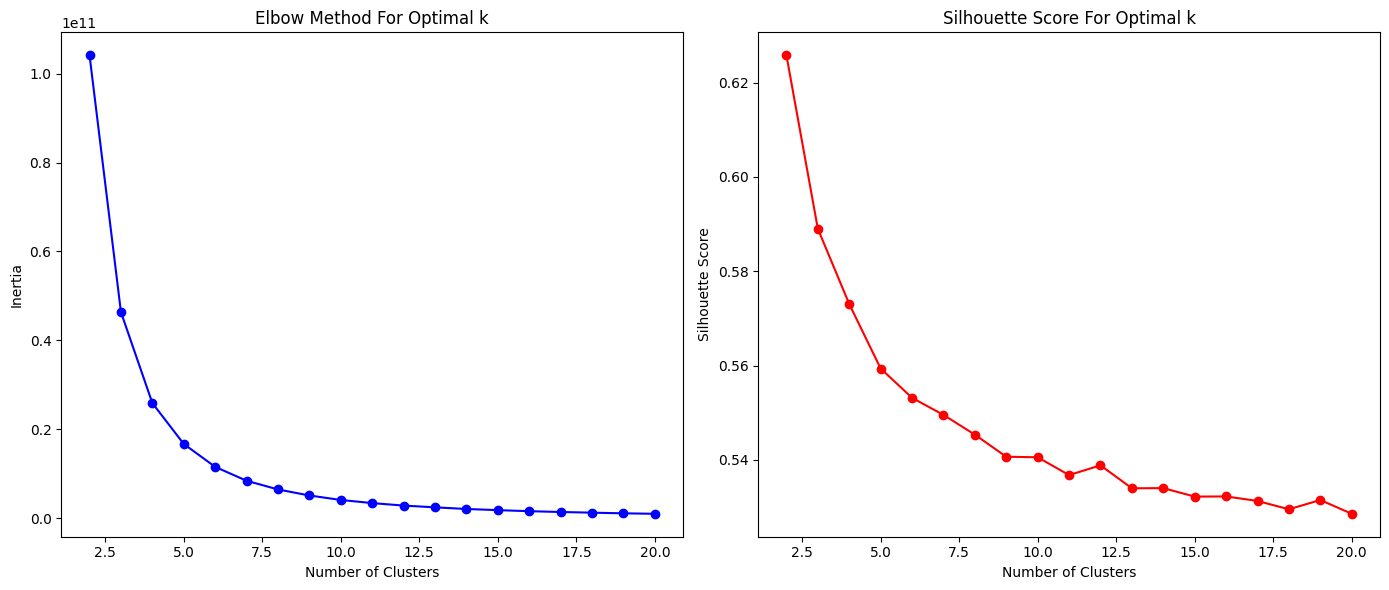

In [12]:
X = df[['follower_count']]

elbow_scores = []
silhouette_scores = []
range_of_clusters = range(2, 21)

for n_clusters in range_of_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    
    elbow_scores.append(kmeans.inertia_)
    
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range_of_clusters, elbow_scores, 'bo-')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(range_of_clusters, silhouette_scores, 'ro-')
plt.title('Silhouette Score For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

[Back to Top](#home)

## Additional Feature Engineering <a class="anchor" id="additional-feature-engineering"></a>

In [13]:
kmeans = KMeans(n_clusters=5, n_init='auto')
df['follower_count_cluster'] = kmeans.fit_predict(df[['follower_count']])

df['verified'] = df['verified'].astype(int)

[Back to Top](#home)

### Wordcloud of the 50 most common words for bots and nots <a class="anchor" id="wordcloud"></a>


Nots:



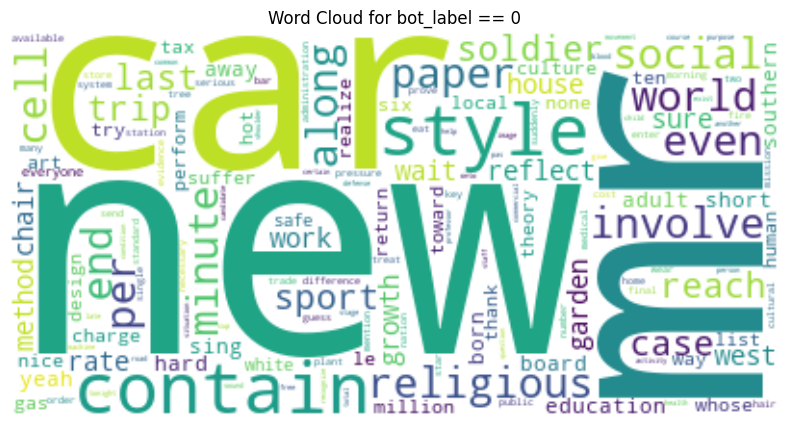


Bots:



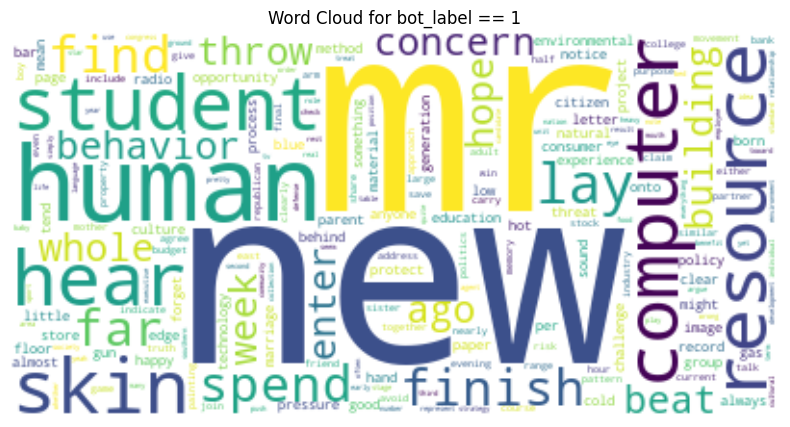

In [14]:
df_bot_0 = df[df['bot_label'] == 0]['cleaned_tweet']
df_bot_1 = df[df['bot_label'] == 1]['cleaned_tweet']

text_bot_0 = " ".join(tweet for tweet in df_bot_0)
text_bot_1 = " ".join(tweet for tweet in df_bot_1)

wordcloud_bot_0 = WordCloud(background_color="white").generate(text_bot_0)

wordcloud_bot_1 = WordCloud(background_color="white").generate(text_bot_1)

print('\nNots:\n')
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_bot_0, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for bot_label == 0")
plt.show()

print('\nBots:\n')
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_bot_1, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for bot_label == 1")
plt.show()

[Back to Top](#home)

### Indicate if the tweet contains the top 50 words from bot or not <a class="anchor" id="tweet-contains"></a>

In [15]:
tweets_bot_0 = df[df['bot_label'] == 0]['cleaned_tweet']
tweets_bot_1 = df[df['bot_label'] == 1]['cleaned_tweet']

words_bot_0 = " ".join(tweets_bot_0).split()
words_bot_1 = " ".join(tweets_bot_1).split()

freq_bot_0 = Counter(words_bot_0)
freq_bot_1 = Counter(words_bot_1)

top_50_words_bot_0 = [word for word, count in freq_bot_0.most_common(50)]
top_50_words_bot_1 = [word for word, count in freq_bot_1.most_common(50)]

set_top_50_bot_0 = set(top_50_words_bot_0)
set_top_50_bot_1 = set(top_50_words_bot_1)

common_words = set_top_50_bot_0.intersection(set_top_50_bot_1)

unique_words_bot_0 = set_top_50_bot_0.difference(set_top_50_bot_1)

unique_words_bot_1 = set_top_50_bot_1.difference(set_top_50_bot_0)

df['contains_unique_nonbotwords'] = df['cleaned_tweet'].apply(contains_unique_words_bot_0).astype(int)
df['contains_unique_botwords'] = df['cleaned_tweet'].apply(contains_unique_words_bot_1).astype(int)

[Back to Top](#home)

## Exploratory Data Analaysis <a class="anchor" id="eda"></a>

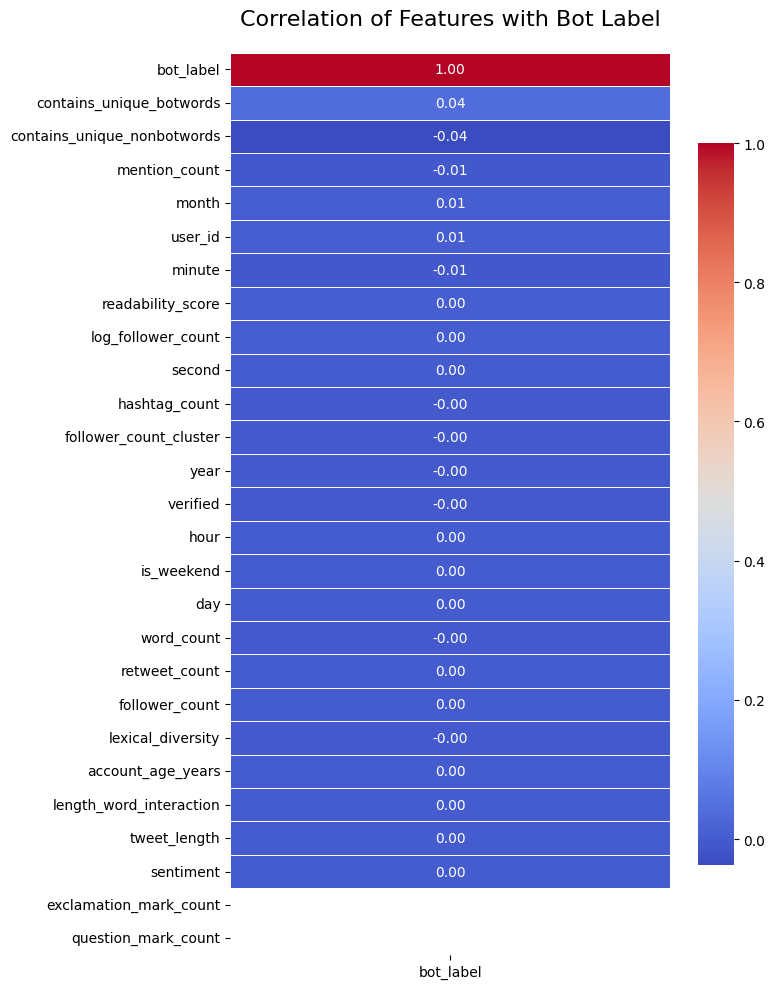

In [16]:
columns_to_exclude = ['time_of_day']
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in columns_to_exclude]

correlation_matrix = df[numeric_cols].corr()

correlation_with_target = correlation_matrix[['bot_label']].sort_values(by='bot_label', key=abs, ascending=False)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 10))
sns.heatmap(correlation_with_target, 
            annot=True, 
            cmap='coolwarm', 
            fmt=".2f",
            linewidths=.5,
            cbar_kws={"shrink": .8})

plt.title('Correlation of Features with Bot Label', fontsize=16, pad=20)
plt.tight_layout()
plt.show()


The heatmap provides a visualization of correlation coefficients between various social media account features and their likelihood of being bots, with a special focus on the 'bot_label' as a reference for bot classification. Key takeaways include most features showing negligible correlation with bot detection, indicating a lack of strong linear relationships to determine bot status. Specifically, features like 'contains_unique_botwords' and 'contains_unique_nonbotwords' exhibit weak positive and negative correlations, respectively, but fail to serve as strong predictors for bot identification. This suggests the need for more complex models or additional feature engineering to enhance predictive accuracy. The heatmap highlights the necessity for further analysis, potentially involving more sophisticated statistical methods or machine learning algorithms, to uncover deeper patterns or feature interactions not immediately apparent from initial observations.

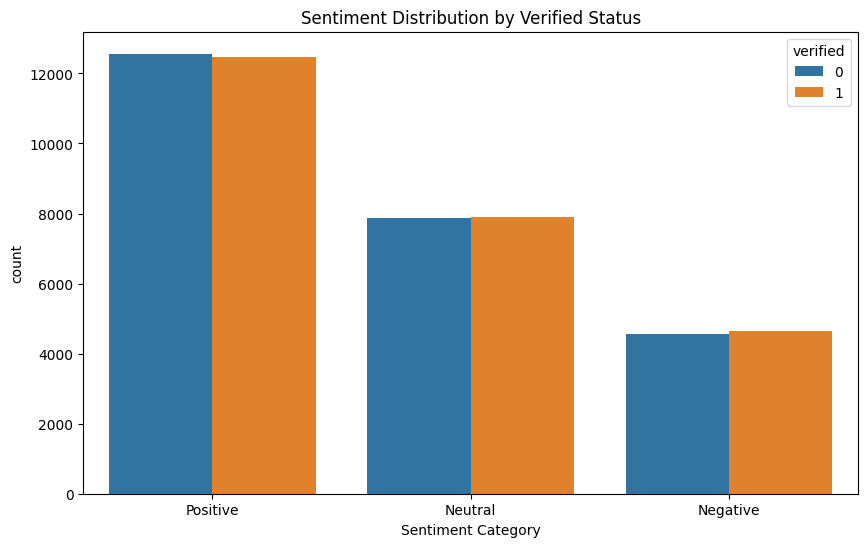

In [17]:
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment_type', hue='verified', data=df)  # Corrected line
plt.title('Sentiment Distribution by Verified Status')
plt.xlabel('Sentiment Category')
plt.show()

The bar chart compares sentiment distribution—positive, neutral, and negative—among verified and unverified social media accounts, revealing a predominant presence of positive sentiments across both account types. Notably, verified accounts display slightly more positive sentiments, while unverified accounts lean marginally more towards neutral sentiments; the counts for negative sentiments are closely matched between the two. Despite these differences, the overall sentiment ratio remains consistent, suggesting similar sentiment expression patterns regardless of verification status. This consistency implies that verification may not significantly impact the sentiment of the content posted, though the observed subtleties suggest potential areas for further investigation. The chart suggests that the dynamics of sentiment expression on social media do not drastically differ between verified and unverified users, indicating a broad appeal of the platform that transcends verification status. For more definitive insights, additional statistical analysis could explore whether the observed differences are meaningful or merely by chance, enhancing the understanding of sentiment distribution dynamics across different user types on the platform.

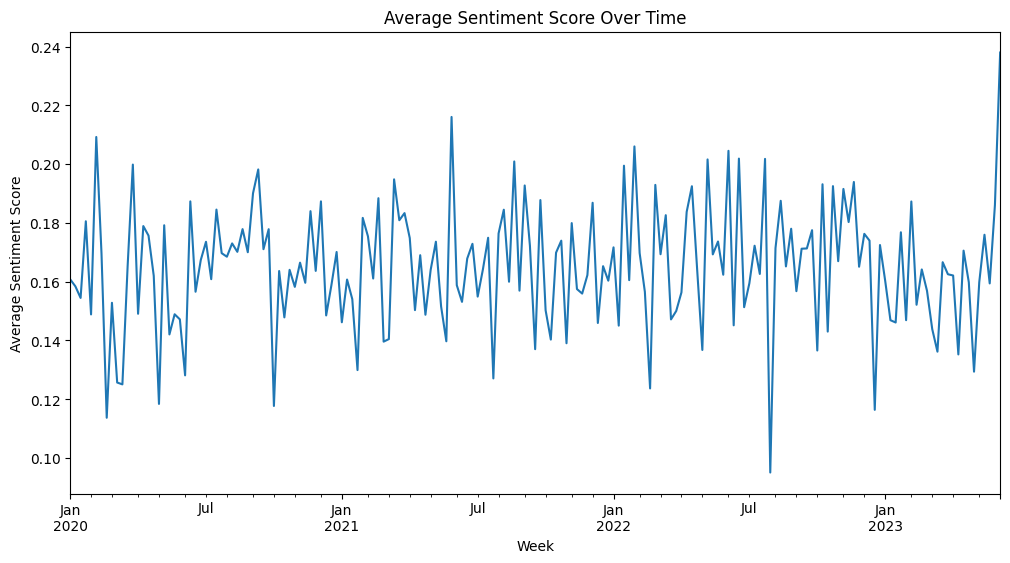

In [18]:
weekly_sentiment = df.resample('W', on='created_at')['sentiment'].mean()


plt.figure(figsize=(12, 6))
weekly_sentiment.plot()
plt.title('Average Sentiment Score Over Time')
plt.xlabel('Week')
plt.ylabel('Average Sentiment Score')
plt.show()

The time series graph depicts the weekly average sentiment scores from January 2020 to January 2023, showcasing fluctuations that mirror changing public moods or reactions to events, without indicating a clear long-term trend. The sentiment scores, oscillating mildly positive between 0.12 and 0.22, suggest a generally optimistic sentiment baseline. Potential seasonal trends or the impact of specific events on sentiment could be discerned with more detailed analysis. The graph hints at outliers possibly tied to significant events, emphasizing the importance of contextual analysis to understand sentiment shifts. Additionally, the consistency in data collection and analysis methodologies is crucial for accurate sentiment tracking over time. This graph highlights the dynamic nature of public sentiment, underlining the need for further investigation, including external data, to fully grasp the underlying factors influencing these sentiment trends.

[Back to Top](#home)

### Geographical and Demographical Insights <a class="anchor" id="geo-and-demo"></a>

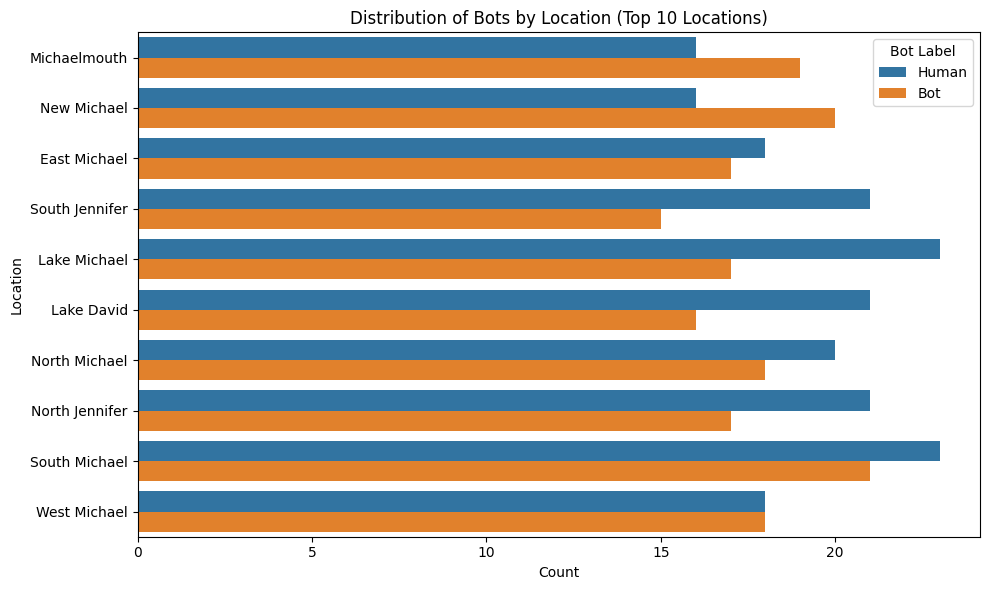

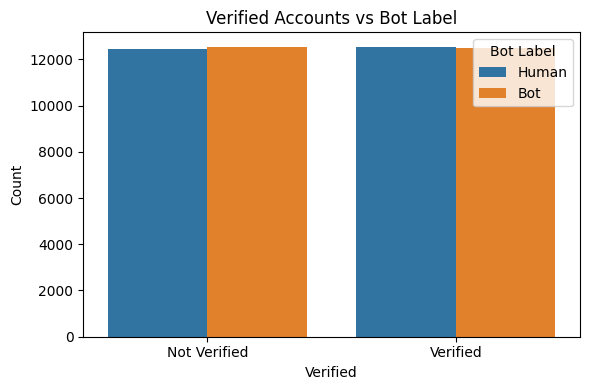

In [19]:
top_locations = df['location'].value_counts().head(10).index
data_top_locations = df[df['location'].isin(top_locations)]
plt.figure(figsize=(10, 6))
sns.countplot(y='location', hue='bot_label', data=data_top_locations)
plt.title('Distribution of Bots by Location (Top 10 Locations)')
plt.xlabel('Count')
plt.ylabel('Location')
plt.legend(title='Bot Label', labels=['Human', 'Bot'])
plt.tight_layout()

## Verified Accounts Analysis
plt.figure(figsize=(6, 4))
sns.countplot(x='verified', hue='bot_label', data=df)
plt.title('Verified Accounts vs Bot Label')
plt.xlabel('Verified')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Verified', 'Verified'])
plt.legend(title='Bot Label', labels=['Human', 'Bot'])
plt.tight_layout()

plt.show()

Geographical and Demographical Insights Analysis

Distribution of Bots by Location (Top 10 Locations)
- The distribution of bots versus human users in the top 10 locations shows a variation in bot activity across different geographical areas. Some locations have a higher prevalence of bots compared to others, indicating that bots might be targeting specific regions or communities.

Verified Accounts vs. Bot Label
- The analysis of verified versus non-verified accounts in relation to the bot label reveals that both verified and non-verified accounts include bots. However, the proportion of bots among verified accounts seems lower compared to non-verified accounts, suggesting that verification might be an effective measure against bot impersonation or that bots are less likely to achieve verified status.

[Back to Top](#home)

### Temporal Analysis <a class="anchor" id="temporal-analysis"></a>

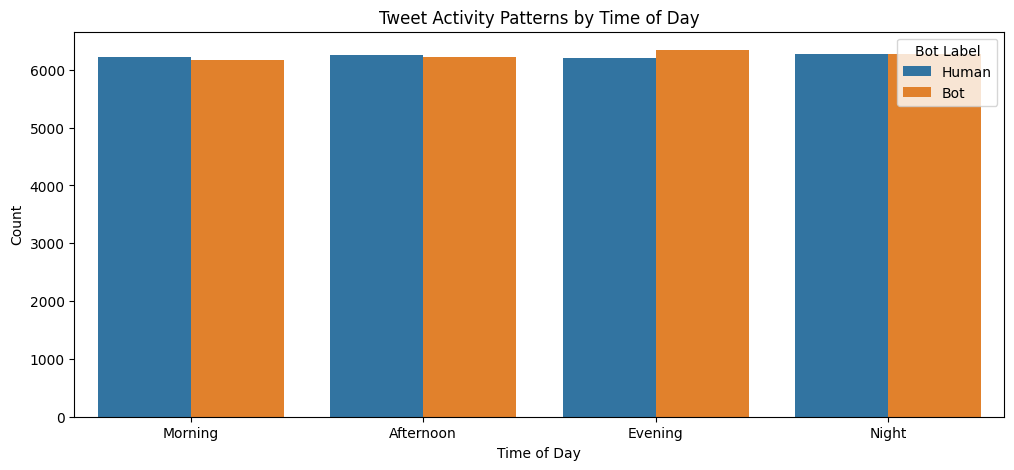

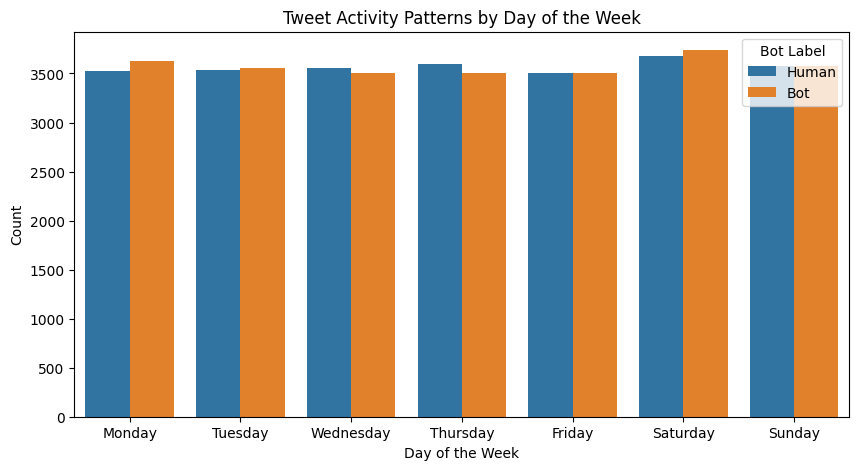

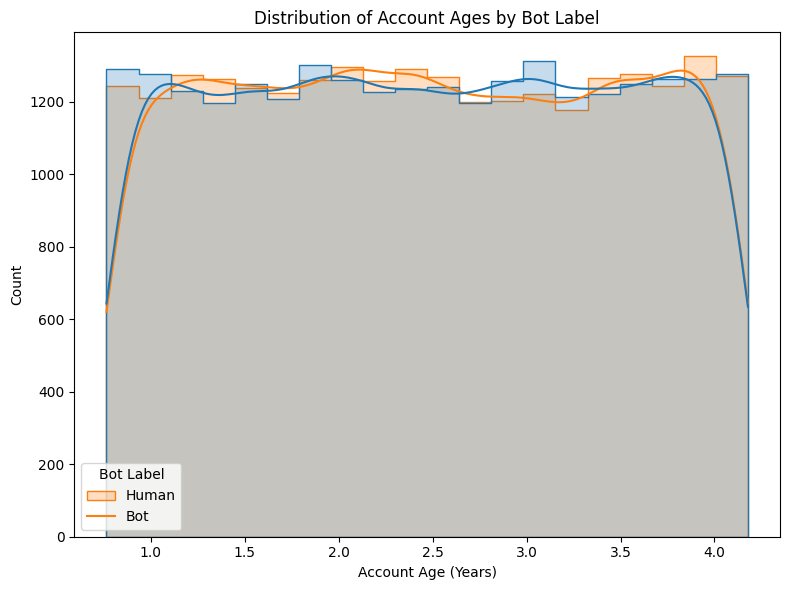

In [20]:
plt.figure(figsize=(12, 5))
sns.countplot(x='time_of_day', hue='bot_label', data=df, order=['Morning', 'Afternoon', 'Evening', 'Night'])
plt.title('Tweet Activity Patterns by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Count')
plt.legend(title='Bot Label', labels=['Human', 'Bot'])

plt.figure(figsize=(10, 5))
sns.countplot(x='day_of_the_week', hue='bot_label', data=df, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Tweet Activity Patterns by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.legend(title='Bot Label', labels=['Human', 'Bot'])

plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='account_age_years', hue='bot_label', element='step', bins=20, kde=True)
plt.title('Distribution of Account Ages by Bot Label')
plt.xlabel('Account Age (Years)')
plt.ylabel('Count')
plt.legend(title='Bot Label', labels=['Human', 'Bot'])

plt.tight_layout()
plt.show()

Temporal Analysis Results

Tweet Activity Patterns Over Time

- By Time of Day: The distribution of tweets by time of day shows different patterns for bots and human users. Both groups are active throughout the day, but there might be slight differences in peak activity times that could indicate preferred operation times for bots versus humans.
- By Day of the Week: Similar to the time of day, tweet activity varies throughout the week for both bots and human users. This analysis can help identify if bots prefer certain days for tweeting, which could be aligned with strategic dissemination of information or targeting specific audience engagement patterns.

Account Age Analysis

The distribution of account ages shows that both bots and human users span a range of account ages, with some peaks and troughs. The Kernel Density Estimate (KDE) overlay indicates the distribution's shape, showing that both newer and older accounts are represented among bots and humans. It's noteworthy to examine if certain age ranges are more prevalent among bots, which could suggest strategies in bot creation and deployment over time.

Insights and Recommendations
- Geographical Targeting by Bots: The presence of bots across different locations suggests geographical targeting may be a strategy for disseminating information or misinformation. Monitoring and analyzing bot activity by location can help in understanding and mitigating such strategies.
- Verification as a Deterrent: The lower proportion of bots among verified accounts indicates that verification processes might deter bot activity or make it harder for bots to achieve verified status. Strengthening verification processes could be an effective measure against bots.
- Temporal Patterns in Bot Activity: Understanding the temporal patterns of bot activity can aid in detecting and mitigating bot influence, especially if bots are programmed to tweet during specific times for maximum impact.
- Account Age as an Indicator: The range of account ages among bots and humans suggests that account age alone might not be a reliable indicator of bot activity. However, it's worth exploring if combinations of features, including account age, can improve bot detection algorithms.

[Back to Top](#home)

### Engagement and Content Analysis <a class="anchor" id="ec-analysis"></a>

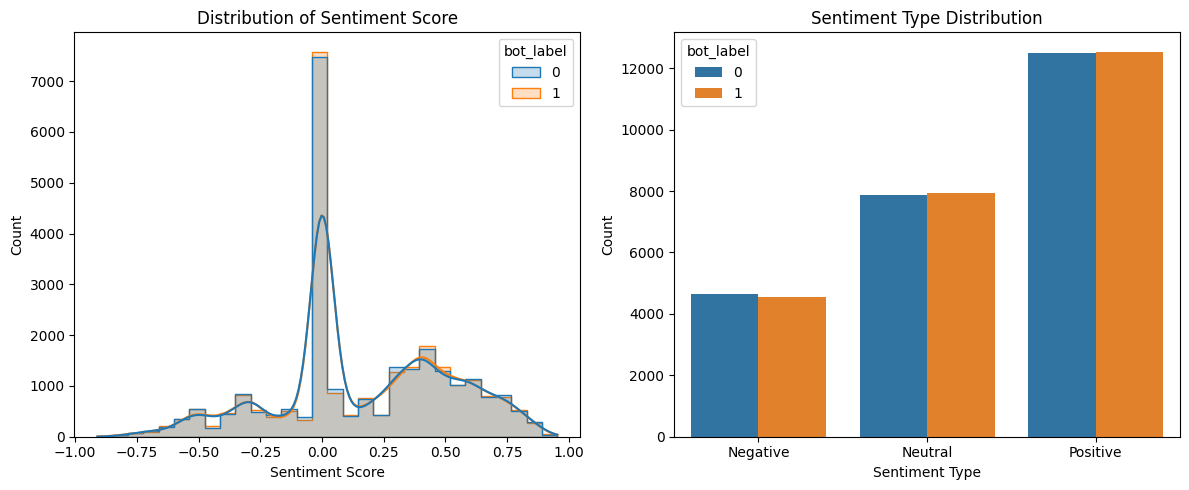

retweet_count  mention_count  follower_count
retweet_count        1.000000      -0.000020       -0.007624
mention_count       -0.000020       1.000000        0.003265
follower_count      -0.007624       0.003265        1.000000

In [21]:
engagement_features = ['retweet_count', 'mention_count', 'follower_count']
correlations = df[engagement_features].corr()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=df, x='sentiment', hue='bot_label', element='step', bins=30, kde=True)
plt.title('Distribution of Sentiment Score')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(x='sentiment_type', hue='bot_label', data=df, order=['Negative', 'Neutral', 'Positive'])
plt.title('Sentiment Type Distribution')
plt.xlabel('Sentiment Type')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

correlations

Engagement Metrics Correlation

The correlation matrix for engagement metrics (retweet_count, mention_count, follower_count) reveals very low correlation coefficients among these variables. This indicates that, at least linearly, there's little to no direct relationship between these metrics within the dataset. For instance, the number of retweets doesn't strongly correlate with the number of mentions or the follower count, suggesting that high engagement in one aspect doesn't necessarily mean high engagement in others.

Sentiment Analysis
- Distribution of Sentiment Score: The sentiment scores for tweets show a broad distribution for both bots and human users, with both groups producing content across the sentiment spectrum. However, the overlay of distributions might hint at subtle differences in sentiment profiles between bots and humans that could be explored further.
- Sentiment Type Distribution: When looking at the sentiment type (Negative, Neutral, Positive), both bots and human users contribute to all sentiment types. The presence of bots across all sentiment types suggests that they are programmed to mimic a range of emotional expressions, or that their activities encompass a wide variety of content types.

Advanced Bot Behavior Analysis

Given the initial findings from the engagement and sentiment analysis, it's evident that understanding bot behavior requires a multifaceted approach, considering not just one or two features, but a combination of them.

[Back to Top](#home)

### Temporal Dynamics: Activity Trends Over Time <a class="anchor" id="temporal-dynamics"></a>

<Figure size 1400x600 with 0 Axes>

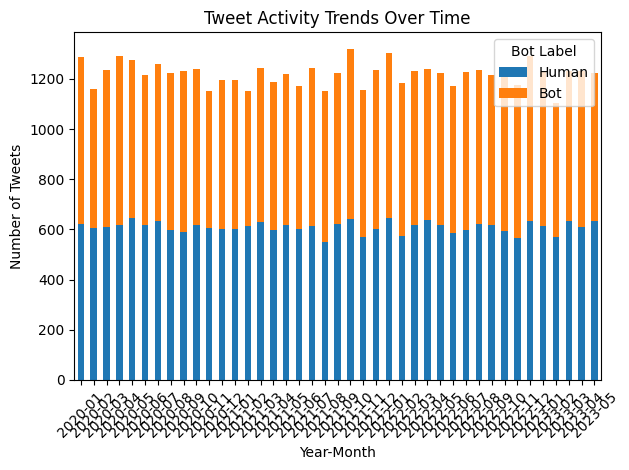

In [22]:
df['year_month'] = df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2)

plt.figure(figsize=(14, 6))
df.groupby(['year_month', 'bot_label']).size().unstack(fill_value=0).plot(kind='bar', stacked=True)
plt.title('Tweet Activity Trends Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.legend(title='Bot Label', labels=['Human', 'Bot'])
plt.tight_layout()
plt.show()

The stacked bar chart illustrates monthly tweet activity, distinguishing between human and bot contributions. It shows consistent engagement from both groups over time, with bots sometimes matching or exceeding human tweet volumes, highlighting their significant presence. Despite this, humans also maintain considerable activity levels, indicating the platform's role in fostering human interaction. The tweet volume ratio between humans and bots remains stable across the observed period, suggesting unchanged account behaviors or platform policies. Further analysis, especially of tweet content, could provide insights into bots' roles in information dissemination or influence. The accuracy of distinguishing bots from humans is critical for the validity of these observations, underscoring the importance of the classification methodology. Overall, the chart effectively portrays the dynamic interaction between humans and bots on the platform.

[Back to Top](#home)

### Language Complexity and Diversity <a class="anchor" id="language-complexity"></a>

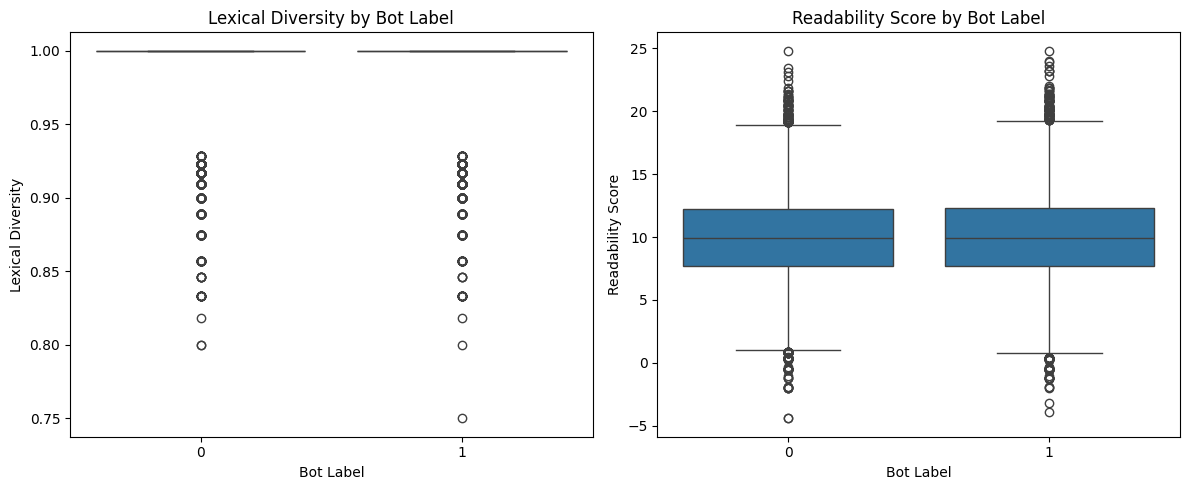

In [23]:
plt.figure(figsize=(12, 5))

# Lexical Diversity
plt.subplot(1, 2, 1)
sns.boxplot(x='bot_label', y='lexical_diversity', data=df)
plt.title('Lexical Diversity by Bot Label')
plt.xlabel('Bot Label')
plt.ylabel('Lexical Diversity')

# Readability Score
plt.subplot(1, 2, 2)
sns.boxplot(x='bot_label', y='readability_score', data=df)
plt.title('Readability Score by Bot Label')
plt.xlabel('Bot Label')
plt.ylabel('Readability Score')

plt.tight_layout()
plt.show()

The boxplots compare 'Lexical Diversity' and 'Readability Score' between human and bot accounts on social media. Both groups show similar lexical diversity, with humans having a slightly higher median, and a wide range of readability scores, suggesting no marked difference in text clarity between them. Outliers indicate texts with unusual word variety or simplicity. These findings suggest that lexical diversity and readability alone may not clearly differentiate bots from humans, pointing to the potential need for additional linguistic features to distinguish between them effectively. The data indicates that bots may be mimicking human language patterns closely.

[Back to Top](#home)

### Topic Modeling <a class="anchor" id="topic-modeling-eda"></a>

In [24]:
text_data = df['cleaned_tweet']

vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(text_data)

lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(dtm)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

Topic 0:
suddenly guess send experience continue work reflect management future rate
Topic 1:
remain argue example article mr son market certain inside according
Topic 2:
ground cost kid event piece million head man thousand produce
Topic 3:
pressure end general improve lead true right finish sit prevent
Topic 4:
soldier structure language development young support professional final likely dream


[Back to Top](#home)

### Sentiment Over Time <a class="anchor" id="sentiment-over-time"></a>

In [25]:
df.columns

Index(['user_id', 'username', 'tweet', 'retweet_count', 'mention_count',
       'follower_count', 'verified', 'bot_label', 'location', 'created_at',
       'hashtags', 'year', 'month', 'day', 'day_of_the_week', 'hour', 'minute',
       'second', 'time_of_day', 'tweet_length', 'word_count', 'hashtag_count',
       'exclamation_mark_count', 'question_mark_count', 'is_weekend',
       'log_follower_count', 'length_word_interaction', 'account_age_years',
       'lexical_diversity', 'readability_score', 'cleaned_tweet', 'sentiment',
       'sentiment_type', 'follower_count_cluster',
       'contains_unique_nonbotwords', 'contains_unique_botwords',
       'year_month'],
      dtype='object')

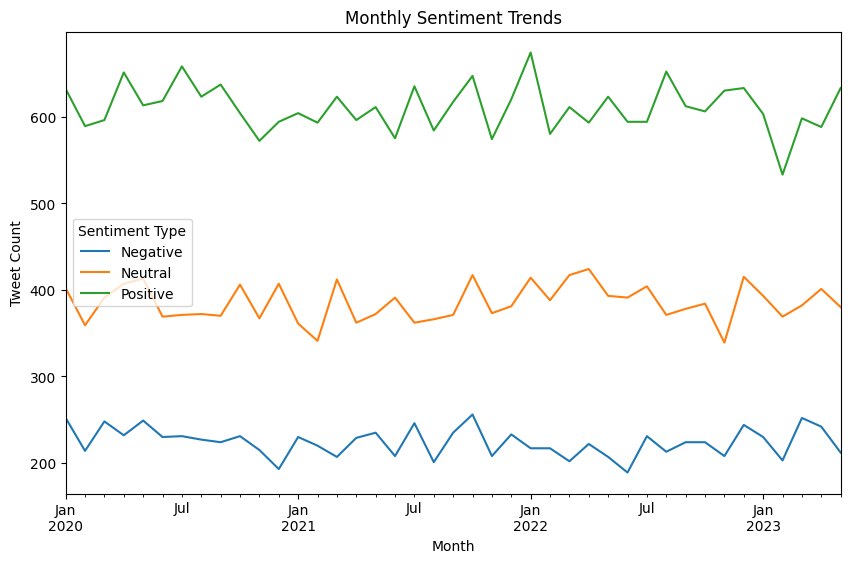

In [26]:
df2 = df.copy()
df2 = df2.set_index('created_at')  # Here, we don't use inplace=True

monthly_sentiment = df2.resample('M')['sentiment_type'].value_counts().unstack(fill_value=0)

monthly_sentiment.plot(kind='line', figsize=(10, 6))
plt.title('Monthly Sentiment Trends')
plt.ylabel('Tweet Count')
plt.xlabel('Month')
plt.legend(title='Sentiment Type')
plt.show()

The line graph shows monthly tweet sentiment counts over three years, revealing a consistent prevalence of positive sentiment tweets and a steady, lower frequency of negative sentiment tweets. Neutral tweets fluctuate moderately without showing a clear long-term trend. While no distinct seasonal patterns are immediately visible, a deeper analysis might reveal such trends influenced by external events or cultural shifts. The graph's reliability depends on consistent data collection and sentiment analysis methods across the observed period. Overall, the data suggests a generally positive expression trend on social media.

[Back to Top](#home)

### Sentiment and Engagement Correlation <a class="anchor" id="se-corr"></a>

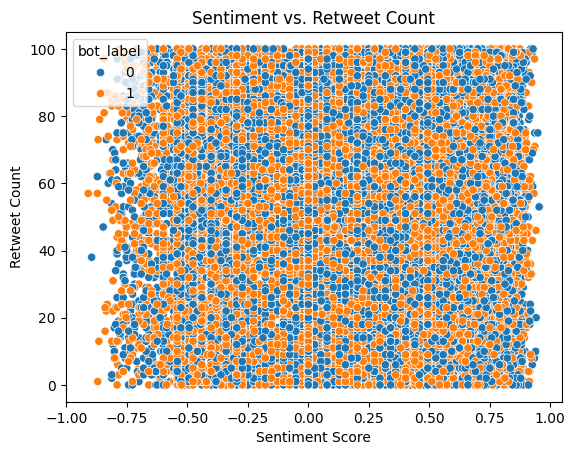

In [27]:
sns.scatterplot(x='sentiment', y='retweet_count', hue='bot_label', data=df)
plt.title('Sentiment vs. Retweet Count')
plt.xlabel('Sentiment Score')
plt.ylabel('Retweet Count')
plt.show()

The scatter plot examines the interplay between sentiment scores and retweet counts on a social media platform, differentiating between bot (1) and human (0) accounts. Sentiment scores span from highly negative to highly positive for both account types, with a notable concentration around the neutral midpoint. Most tweets, from bots and humans alike, garner only a handful of retweets, evidenced by the clustering of data points at the lower end of the retweet count.

Both human and bot accounts display a comparable range of sentiment scores and retweet counts, with no distinct pattern emerging that associates sentiment with the likelihood of being retweeted. This observation suggests sentiment score is not a definitive indicator of a tweet's retweet potential.

The similarity in the distribution of sentiment scores and retweet counts for both bots and humans may indicate that bots are emulating human engagement patterns. However, the dense overlap of data points poses challenges in distinguishing between the two, highlighting the need for more intricate analysis to discern underlying trends.

In summary, the scatter plot reveals the intricate nature of social media engagement, where neither sentiment nor retweets clearly differentiate human from bot activity, calling for more advanced methods to parse these complex interactions.

[Back to Top](#home)

## Machine Learning Models <a class="anchor" id="machine-learning-models"></a>

### Random Forest Classification <a class="anchor" id="random-forest-classification"></a>

In [28]:
numerical_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical),
        ('cat', categorical_transformer, categorical)
    ])

In [29]:
model1 = RandomForestClassifier()

In [30]:
sampled_df = df.sample(frac=0.2, random_state=0)
X = sampled_df.drop('bot_label', axis=1)
y = sampled_df['bot_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [31]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model1', model1)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['user_id', 'retweet_count', 'mention_count', 'follower_count'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['username', 'tweet', 'location', 'created_at', 'hashtags'], dtype='object'))])),
                ('model1', RandomForestClassifier())])

In [32]:
preds = pipeline.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.50      0.57      0.53       985
           1       0.51      0.45      0.48      1015

    accuracy                           0.50      2000
   macro avg       0.51      0.51      0.50      2000
weighted avg       0.51      0.50      0.50      2000



[Back to Top](#home)

### Logistic Regression <a class="anchor" id="logistic-regression"></a>

In [33]:
model2 = LogisticRegression(max_iter=1000)

pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model2', model2)])

pipeline_lr.fit(X_train, y_train)
preds_lr = pipeline_lr.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, preds_lr))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.43      0.46       985
           1       0.50      0.56      0.53      1015

    accuracy                           0.50      2000
   macro avg       0.49      0.50      0.49      2000
weighted avg       0.50      0.50      0.49      2000



[Back to Top](#home)

### Support Vector Machines (SVM) <a class="anchor" id="support-vector-machines-svm"></a>

In [34]:
model3 = SVC(kernel='linear')

pipeline_svm = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model3', model3)])

pipeline_svm.fit(X_train, y_train)
preds_svm = pipeline_svm.predict(X_test)
print("SVM Classification Report:")
print(classification_report(y_test, preds_svm))

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.44      0.46       985
           1       0.51      0.56      0.53      1015

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



[Back to Top](#home)

### K-Nearest Neighbors (KNN) <a class="anchor" id="k-nearest-neighbors-knn"></a>

In [35]:
model_knn = KNeighborsClassifier(n_neighbors=5)
pipeline_knn = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model4', model_knn)])

pipeline_knn.fit(X_train, y_train)
preds_knn = pipeline_knn.predict(X_test)
print(classification_report(y_test, preds_knn))

              precision    recall  f1-score   support

           0       0.49      0.50      0.50       985
           1       0.51      0.51      0.51      1015

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



[Back to Top](#home)

### Gradient Boosting Machines (GBM), including XGBoost, LightGBM, and CatBoost <a class="anchor" id="gradient-boosting-machines-gbm-including-xgboost-lightgbm-and-catboost"></a>

In [36]:
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model_xgb', model_xgb)])

pipeline_xgb.fit(X_train, y_train)
preds_xgb = pipeline_xgb.predict(X_test)
print(classification_report(y_test, preds_xgb))

              precision    recall  f1-score   support

           0       0.50      0.48      0.49       985
           1       0.51      0.53      0.52      1015

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



In [37]:
model_lgbm = LGBMClassifier()

pipeline_lgbm = Pipeline(steps=[('preprocessor', preprocessor),
                                ('model_lgbm', model_lgbm)])

pipeline_lgbm.fit(X_train, y_train)
preds_lgbm = pipeline_lgbm.predict(X_test)
print(classification_report(y_test, preds_lgbm))

[LightGBM] [Info] Number of positive: 4008, number of negative: 3992
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501000 -> initscore=0.004000
[LightGBM] [Info] Start training from score 0.004000
              precision    recall  f1-score   support

           0       0.51      0.51      0.51       985
           1       0.52      0.52      0.52      1015

    accuracy                           0.52      2000
   macro avg       0.52      0.52      0.52      2000
weighted avg       0.52      0.52      0.52      2000



In [38]:
model_catboost = CatBoostClassifier(verbose=0)

pipeline_catboost = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('model_catboost', model_catboost)])

pipeline_catboost.fit(X_train, y_train)
preds_catboost = pipeline_catboost.predict(X_test)

print(classification_report(y_test, preds_catboost))

              precision    recall  f1-score   support

           0       0.48      0.47      0.47       985
           1       0.50      0.51      0.51      1015

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000



[Back to Top](#home)

### Majority Voting: Joined ALL three ensemble methods above <a class="anchor" id="majority-voting-joined-all-three-ensemble-methods-above"></a>

In [39]:
ensemble_voting = VotingClassifier(estimators=[
    ('rf', pipeline),
    ('xgb', pipeline_xgb),
    ('lgbm', pipeline_lgbm)],
    voting='hard')

ensemble_voting.fit(X_train, y_train)
preds_ensemble = ensemble_voting.predict(X_test)

print(classification_report(y_test, preds_ensemble))

[LightGBM] [Info] Number of positive: 4008, number of negative: 3992
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501000 -> initscore=0.004000
[LightGBM] [Info] Start training from score 0.004000
              precision    recall  f1-score   support

           0       0.50      0.53      0.51       985
           1       0.51      0.48      0.49      1015

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



[Back to Top](#home)

## Neural Networks/Deep Learning <a class="anchor" id="neural-networksdeep-learning"></a>

### Multilayer Perceptrons (MLP) <a class="anchor" id="multilayer-perceptrons-mlp"></a>

In [40]:
X_train_transformed = preprocessor.fit_transform(X_train).toarray()
X_test_transformed = preprocessor.transform(X_test).toarray()

input_dim = X_train_transformed.shape[1]

model = create_model(input_dim=input_dim)
model.fit(X_train_transformed, y_train, epochs=100, batch_size=10, verbose=1)
preds = model.predict(X_test_transformed)
preds = (preds > 0.5).astype(int)

print(classification_report(y_test, preds))



Epoch 1/100


800/800 [==============================] - 19s 23ms/step - loss: 0.6934 - accuracy: 0.5095
Epoch 2/100
800/800 [==============================] - 18s 23ms/step - loss: 0.2119 - accuracy: 0.9161
Epoch 3/100
800/800 [==============================] - 18s 23ms/step - loss: 0.0023 - accuracy: 0.9991
Epoch 4/100
800/800 [==============================] - 19s 24ms/step - loss: 3.4213e-05 - accuracy: 1.0000
Epoch 5/100
800/800 [==============================] - 19s 24ms/step - loss: 2.0950e-05 - accuracy: 1.0000
Epoch 6/100
800/800 [==============================] - 19s 24ms/step - loss: 1.4142e-05 - accuracy: 1.0000
Epoch 7/100
800/800 [==============================] - 19s 24ms/step - loss: 9.5541e-06 - accuracy: 1.0000
Epoch 8/100
800/800 [==============================] - 19s 24ms/step - loss: 6.3661e-06 - accuracy: 1.0000
Epoch 9/100
800/800 [==============================] - 18s 23ms/step - loss: 4.1625e-06 - accuracy: 1.0000
Epoch 10/100
800/800 [=======================

MLPs are powerful because they can learn complex patterns by adjusting connections in a network of layers.
Our results show the model is quite good at recognizing non-bots but struggles to accurately identify bots, as seen in the high recall for non-bots and low recall for bots.
The precision being equal for both classes means our model is consistent in its accuracy rate across both bot and non-bot predictions.
Overall, the model's accuracy is around 49%, indicating it's not performing well in distinguishing between bots and non-bots, similar to making a guess.
The challenge now is to improve the model's ability to detect bots without losing its performance on non-bots, possibly by further tuning the model or using more sophisticated neural network architectures. So I'm going to work with RNN, BERT and LSTM

[Back to Top](#home)

### Recurrent Neural Networks (RNN) <a class="anchor" id="recurrent-neural-networks-rnn"></a>

In [41]:
texts = df['cleaned_tweet'].astype(str)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
max_sequence_length = max(len(seq) for seq in sequences)
word_index = tokenizer.word_index

data = pad_sequences(sequences, maxlen=max_sequence_length)

In [42]:
model_rnn = Sequential()
model_rnn.add(Embedding(len(word_index) + 1, 128, input_length=max_sequence_length))
model_rnn.add(SimpleRNN(64))
model_rnn.add(Dense(1, activation='sigmoid'))

model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_rnn.fit(data, df['bot_label'], epochs=5, batch_size=128, validation_split=0.2)

Epoch 1/5
313/313 [==============================] - 2s 3ms/step - loss: 0.6952 - accuracy: 0.4990 - val_loss: 0.6948 - val_accuracy: 0.4965
Epoch 2/5
313/313 [==============================] - 1s 2ms/step - loss: 0.6816 - accuracy: 0.5620 - val_loss: 0.7041 - val_accuracy: 0.4940
Epoch 3/5
313/313 [==============================] - 1s 2ms/step - loss: 0.6584 - accuracy: 0.6059 - val_loss: 0.7239 - val_accuracy: 0.4977
Epoch 4/5
313/313 [==============================] - 1s 2ms/step - loss: 0.6376 - accuracy: 0.6350 - val_loss: 0.7367 - val_accuracy: 0.4976
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.6225 - accuracy: 0.6518 - val_loss: 0.7602 - val_accuracy: 0.4956


[Back to Top](#home)

### Long Short-Term Memory (LSTM) Networks <a class="anchor" id="long-short-term-memory-lstm-networks"></a>

In [43]:
model_lstm = Sequential()
model_lstm.add(Embedding(len(word_index) + 1, 128, input_length=max_sequence_length))
model_lstm.add(LSTM(64))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.fit(data, df['bot_label'], epochs=5, batch_size=128, validation_split=0.2)

Epoch 1/5
313/313 [==============================] - 3s 6ms/step - loss: 0.6934 - accuracy: 0.4977 - val_loss: 0.6936 - val_accuracy: 0.4953
Epoch 2/5
313/313 [==============================] - 2s 5ms/step - loss: 0.6902 - accuracy: 0.5340 - val_loss: 0.6957 - val_accuracy: 0.4946
Epoch 3/5
313/313 [==============================] - 2s 5ms/step - loss: 0.6842 - accuracy: 0.5541 - val_loss: 0.7050 - val_accuracy: 0.4926
Epoch 4/5
313/313 [==============================] - 2s 5ms/step - loss: 0.6786 - accuracy: 0.5669 - val_loss: 0.7085 - val_accuracy: 0.4900
Epoch 5/5
313/313 [==============================] - 2s 5ms/step - loss: 0.6725 - accuracy: 0.5776 - val_loss: 0.7199 - val_accuracy: 0.4908


[Back to Top](#home)

### Prediction for RNN and LSTM <a class="anchor" id="prediction-for-rnn-and-lstm"></a>

In [44]:
model_rnn.predict(data)
predictions = model_rnn.predict(data)

1563/1563 [==============================] - 1s 733us/step


In [45]:
predicted_classes = (predictions > 0.5).astype(int)

In [46]:
true_labels = df['bot_label']
accuracy = accuracy_score(true_labels, predicted_classes)
print("Accuracy:", accuracy)
print(classification_report(true_labels, predicted_classes))

Accuracy: 0.66802
              precision    recall  f1-score   support

           0       0.67      0.67      0.67     24982
           1       0.67      0.66      0.67     25018

    accuracy                           0.67     50000
   macro avg       0.67      0.67      0.67     50000
weighted avg       0.67      0.67      0.67     50000



In [47]:
model_lstm.predict(data)
predictions_2 = model_lstm.predict(data)

1563/1563 [==============================] - 2s 1ms/step


In [48]:
predicted_classes = (predictions_2 > 0.5).astype(int)

In [49]:
true_labels = df['bot_label']
accuracy = accuracy_score(true_labels, predicted_classes)
print("Accuracy:", accuracy)
print(classification_report(true_labels, predicted_classes))

Accuracy: 0.58216
              precision    recall  f1-score   support

           0       0.58      0.62      0.60     24982
           1       0.59      0.54      0.57     25018

    accuracy                           0.58     50000
   macro avg       0.58      0.58      0.58     50000
weighted avg       0.58      0.58      0.58     50000



[Back to Top](#home)

## Enhancing models with feature selections <a class="anchor" id="below-are-the-machine-learning-model-that-i-have-used-by-enhancing-feature-selections"></a>

 Improving Features

In [50]:
df.columns

Index(['user_id', 'username', 'tweet', 'retweet_count', 'mention_count',
       'follower_count', 'verified', 'bot_label', 'location', 'created_at',
       'hashtags', 'year', 'month', 'day', 'day_of_the_week', 'hour', 'minute',
       'second', 'time_of_day', 'tweet_length', 'word_count', 'hashtag_count',
       'exclamation_mark_count', 'question_mark_count', 'is_weekend',
       'log_follower_count', 'length_word_interaction', 'account_age_years',
       'lexical_diversity', 'readability_score', 'cleaned_tweet', 'sentiment',
       'sentiment_type', 'follower_count_cluster',
       'contains_unique_nonbotwords', 'contains_unique_botwords',
       'year_month'],
      dtype='object')

In [51]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['account_creation_year'] = df['created_at'].dt.year
df['account_creation_month'] = df['created_at'].dt.month
df['account_creation_day'] = df['created_at'].dt.day
df['account_creation_hour'] = df['created_at'].dt.hour

In [52]:
df['retweet_mention_ratio'] = df['retweet_count'] / (df['mention_count'] + 1)
df['followers_friends_ratio'] = df['follower_count'] / (df['mention_count'] + 1)

In [53]:
df['unique_word_count'] = df['tweet'].apply(lambda x: len(set(str(x).split())))

In [54]:
df.dtypes

user_id                                 int64
username                               object
tweet                                  object
retweet_count                           int64
mention_count                           int64
follower_count                          int64
verified                                int32
bot_label                               int64
location                               object
created_at                     datetime64[ns]
hashtags                               object
year                                    int64
month                                   int64
day                                     int64
day_of_the_week                        object
hour                                    int64
minute                                  int64
second                                  int64
time_of_day                          category
tweet_length                            int64
word_count                              int64
hashtag_count                     

[Back to Top](#home)

## Random Forest Classification Models <a class="anchor" id="random-forest-classification-models"></a>

### Feature Selection 1 using numerical variables only. <a class="anchor" id="feature-selection-1-using-numerical-variables-only"></a>


In [55]:
sampled_df = df.sample(frac=0.2, random_state=0)
X = sampled_df.drop(['bot_label', 
                     'username', 
                     'tweet', 
                     'location', 
                     'created_at', 
                     'hashtags', 
                     'day_of_the_week', 
                     'time_of_day', 
                     'cleaned_tweet', 
                     'sentiment_type', 
                     'year_month'], axis=1)
y = sampled_df['bot_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [56]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [57]:
clf = RandomForestClassifier()
clf.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [58]:
model = SelectFromModel(clf, prefit=True)
X_important_train = model.transform(X_train_scaled)
X_important_test = model.transform(X_test_scaled)

In [59]:
X_important_train.shape, X_important_test.shape, clf.feature_importances_

((8000, 17),
 (2000, 17),
 array([0.05809098, 0.04820291, 0.02071625, 0.0506023 , 0.00845255,
        0.01144189, 0.02784661, 0.03856253, 0.03624866, 0.05031517,
        0.04930027, 0.04121112, 0.01828664, 0.02429457, 0.        ,
        0.        , 0.00773205, 0.05014469, 0.04427587, 0.05112612,
        0.00335845, 0.04919513, 0.04552467, 0.01473762, 0.00691503,
        0.00710194, 0.01168571, 0.02777029, 0.03758253, 0.03555341,
        0.05234555, 0.05301325, 0.01836525]))

In [60]:
clf_important = RandomForestClassifier()
clf_important.fit(X_important_train, y_train)

preds_important = clf_important.predict(X_important_test)

accuracy = accuracy_score(y_test, preds_important)
precision = precision_score(y_test, preds_important)
recall = recall_score(y_test, preds_important)
f1 = f1_score(y_test, preds_important)

accuracy, precision, recall, f1

(0.4995, 0.5070993914807302, 0.49261083743842365, 0.49975012493753124)

[Back to Top](#home)

### Feature Selection 2 using numerical variables only <a class="anchor" id="feature-selection-2-using-numerical-variables-only"></a>

In [61]:
sampled_df = df.sample(frac=0.2, random_state=0)
X = sampled_df.drop(['bot_label', 
                     'username', 
                     'tweet', 
                     'location', 
                     'created_at', 
                     'hashtags', 
                     'day_of_the_week', 
                     'time_of_day', 
                     'cleaned_tweet', 
                     'sentiment_type', 
                     'year_month'], axis=1)
y = sampled_df['bot_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [62]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [63]:
clf = RandomForestClassifier()
clf.fit(X_train_scaled, y_train)
model = SelectFromModel(clf, prefit=True)
X_important_train = model.transform(X_train_scaled)
X_important_test = model.transform(X_test_scaled)

In [64]:
X_important_train.shape, X_important_test.shape, clf.feature_importances_

((8000, 17),
 (2000, 17),
 array([0.05676902, 0.04988674, 0.02072821, 0.04926752, 0.00884909,
        0.01160402, 0.02705364, 0.03869603, 0.03574941, 0.05010746,
        0.05017913, 0.04009359, 0.01866001, 0.02544116, 0.        ,
        0.        , 0.00787129, 0.04991826, 0.04434104, 0.05305555,
        0.00351852, 0.04767196, 0.04557954, 0.01353772, 0.00683565,
        0.00662483, 0.01171823, 0.02751332, 0.03898223, 0.03637342,
        0.05193445, 0.05267306, 0.01876592]))

In [65]:
clf_important = RandomForestClassifier()
clf_important.fit(X_important_train, y_train)

preds_important = clf_important.predict(X_important_test)
accuracy = accuracy_score(y_test, preds_important)
precision = precision_score(y_test, preds_important)
recall = recall_score(y_test, preds_important)
f1 = f1_score(y_test, preds_important)

accuracy, precision, recall, f1

(0.505, 0.512846865364851, 0.4916256157635468, 0.5020120724346077)

[Back to Top](#home)

### Feature Selection 3 using categorical variables only. <a class="anchor" id="feature-selection-3-using-categorical-variables-only"></a>

In [66]:
sampled_df = df.sample(frac=0.1, random_state=0)

X = sampled_df[categorical]
y = sampled_df['bot_label']

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_encoded = encoder.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=0)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [67]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [68]:
clf = RandomForestClassifier()
clf.fit(X_train_scaled, y_train)
model = SelectFromModel(clf, prefit=True)
X_important_train = model.transform(X_train_scaled)
X_important_test = model.transform(X_test_scaled)

In [69]:
clf_important = RandomForestClassifier()
clf_important.fit(X_important_train, y_train)

preds_important = clf_important.predict(X_important_test)
accuracy = accuracy_score(y_test, preds_important)
precision = precision_score(y_test, preds_important)
recall = recall_score(y_test, preds_important)
f1 = f1_score(y_test, preds_important)

accuracy, precision, recall, f1

(0.481, 0.4797979797979798, 0.9916492693110647, 0.6466984343090537)

[Back to Top](#home)

### Feature Selection 4 using categorical variables excluding some features <a class="anchor" id="feature-selection-4-using-categorical-variables-excluding-some-features"></a>

In [70]:
sampled_df = df.sample(frac=0.1, random_state=0)

X = sampled_df.drop(numerical.tolist() + ['tweet', 'bot_label','created_at', 'day_of_the_week', 'time_of_day'], axis=1)
y = sampled_df['bot_label']

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_encoded = encoder.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=0)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [71]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [72]:
clf = RandomForestClassifier()
clf.fit(X_train_scaled, y_train)
model = SelectFromModel(clf, prefit=True)
X_important_train = model.transform(X_train_scaled)
X_important_test = model.transform(X_test_scaled)

In [73]:
clf_important = RandomForestClassifier()
clf_important.fit(X_important_train, y_train)

preds_important = clf_important.predict(X_important_test)
accuracy = accuracy_score(y_test, preds_important)
precision = precision_score(y_test, preds_important)
recall = recall_score(y_test, preds_important)
f1 = f1_score(y_test, preds_important)

accuracy, precision, recall, f1

(0.513, 0.4925373134328358, 0.5511482254697286, 0.5201970443349754)

Overall, enhancing features selections aren't showing any improvements. So, I will stick with neural nets above that has already been improved

[Back to Top](#home)

## Using LIME (explainable AI) <a class="anchor" id="using-lime-explainable-ai"></a>

In [74]:
explainer = LimeTextExplainer(class_names=['Not Bot', 'Bot'])

idx = 0

text_instance = df['cleaned_tweet'].iloc[idx]

exp = explainer.explain_instance(text_instance, predict_wrapper, num_features=10)

exp.show_in_notebook(text=True)

157/157 [==============================] - 0s 763us/step


In [75]:
explainer = LimeTextExplainer(class_names=['Human', 'Bot'])

idx = 1

text_instance = df['cleaned_tweet'].iloc[idx]

exp = explainer.explain_instance(text_instance, predict_wrapper, num_features=10)

exp.show_in_notebook(text=True)

157/157 [==============================] - 0s 757us/step


[Back to Top](#home)

### Lime topic Analysis <a class="anchor" id="lime-topic-analysis"></a>

In [76]:
human_text_data = df[df['bot_label'] == 0]['cleaned_tweet']
bot_text_data = df[df['bot_label'] == 1]['cleaned_tweet']

lda_human, vectorizer_human = perform_lda(human_text_data)
lda_bot, vectorizer_bot = perform_lda(bot_text_data)

no_top_words = 10
print("Human Topics:")
display_topics(lda_human, vectorizer_human.get_feature_names_out(), no_top_words)
print("\nBot Topics:")
display_topics(lda_bot, vectorizer_bot.get_feature_names_out(), no_top_words)

Human Topics:
Topic 0:
guess send know build suddenly usually continue try reflect music
Topic 1:
article example member mr certain market chair according magazine road
Topic 2:
dog social head sport thousand event list card operation nearly
Topic 3:
end pressure true star edge college perform prevent court general
Topic 4:
soldier final structure support language development professional action push dream

Bot Topics:
Topic 0:
experience reveal future painting guess agent best person smile behavior
Topic 1:
argue remain example son certain sister quite make rule section
Topic 2:
ground military cost event total region million use apply hand
Topic 3:
pressure general right meet lead popular doctor store couple sit
Topic 4:
development young structure professional cold spend challenge dream official thank


#### Human Topics:

**Personal Action and Creativity:**
guess send know build suddenly usually continue try reflect music

**Formal and Informative Content:**
article example member mr certain market chair according magazine road

**Recreational and Social Activities:**
dog social head sport thousand event list card operation nearly

**Achievement and Challenge:**
end pressure true star edge college perform prevent court general

**Duty and Aspiration:**
soldier final structure support language development professional action push dream

#### Bot Topics:

**Abstract Experiences and Aspirations:**
experience reveal future painting guess agent best person smile behavior

**Interpersonal and Normative Discussions:**
argue remain example son certain sister quite make rule section

**Strategic and Analytical Focus:**
ground military cost event total region million use apply hand

**Social Connectivity and Lifestyle:**
pressure general right meet lead popular doctor store couple sit

**Professional Development and Gratitude:**
development young structure professional cold spend challenge dream official thank

#### Distinguishing Factors:

Human topics tend to focus on personal actions, creativity, and specific social or recreational activities, suggesting content that might be more experiential or narrative in nature.

Bot topics, on the other hand, appear to cover a broader range of abstract experiences, strategic discussions, and general advice, potentially indicating content that is more informational, advisory, or aimed at broader audience engagement.

[Back to Top](#home)

## SHAP (explainable AI) <a class="anchor" id="using-shap-explainable-ai"></a>

In [77]:
background = data[np.random.choice(data.shape[0], 100, replace=False)]
explainer = shap.KernelExplainer(model_lstm.predict, background)

idx = 0 
instance_to_explain = data[idx:idx+1]

shap_values = explainer.shap_values(instance_to_explain)

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0])

4/4 [==============================] - 0s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

6482/6482 [==============================] - 8s 1ms/step


SHAP plot visually explains the contribution of each feature to a specific model prediction. Features pushing the prediction higher (towards being a bot) are shown in red, and those pushing it lower (towards being human) are in blue. The base value is the model's average output over the dataset, and f(x) is the model's output for this specific instance. If f(x) is higher than the base value, the model leans towards predicting 'bot'; if lower, 'human'. Here, f(x) is very close to the base, suggesting a borderline decision, but slightly more towards 'bot'.

In [78]:
background = data[np.random.choice(data.shape[0], 100, replace=False)]
explainer = shap.KernelExplainer(model_rnn.predict, background)

idx = 0
instance_to_explain = data[idx:idx+1]

shap_values = explainer.shap_values(instance_to_explain)

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0])

4/4 [==============================] - 0s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

6488/6488 [==============================] - 5s 754us/step


[Back to Top](#home)